# 15장 실제 데이터로 만들어 보는 모델

지금까지 한 몇 가지 실습은 참 또는 거짓을 맞히거나 여러 개의 보기 중 하나를 예측하는 분류 문제였습니다. 그런데 이번에는 수치를 예측하는 문제입니다. 준비된 **데이터는 아오와주 에임스 지역에서 2006년부터 2010년까지 거래된 실제 부동산 판매 기록입니다.** 주거 유형, 차고, 자재 및 환경에 대한 80개의 서로 다른 속성을 이용해 집의 가격을 예측해 볼 예정인데 **오랜 시간 사람이 일일이 기록하다 보니 빠진 부분도 많고, 집에 따라 어떤 항목은 범위에서 너무 벗어나 있기도 하며, 또 가격과는 관계가 없는 정보가 포함되어 있기도 합니다.** 실제 현장에서 만나게 되는 이런 류의 데이터를 어떻게 다루어야 하는지 이 장에서 학습해 보겠습니다. 

## 1. 데이터 파악하기
먼저 데이터를 불러와 확인해 보겠습니다.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

# 깃허브에 준비된 데이터를 가져옵니다.
!git clone https://github.com/taehojo/data.git

# 집 값 데이터를 불러옵니다.
df = pd.read_csv("./data/house_train.csv")

# 데이터를 미리 살펴보겠습니다. 
df

Cloning into 'data'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 21 (delta 3), reused 20 (delta 2), pack-reused 0
Unpacking objects: 100% (21/21), done.


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [ ]:
df.shape

(1460, 81)

위 데이터 프레임(df)는 총 1,460개의 행과 81개의 열로 구성되어 있습니다. 즉, 1,460개의 샘플이 있고 (Id열 제외)80개의 속성으로 구성된 것을 알 수 있습니다. 각 열이 어떤 유형의 데이터인지 확인해 보겠습니다.

In [ ]:
# 데이터가 어떤 유형으로 이루어져 있는지 알아봅니다. 
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

정수형(int64), 실수형(float64) 그리고 오브젝트형(object) 형태와 위에서 출력되지 않고 생략된 열이 다른 타입의 테이터일 수도 있습니다.  

## 2. 결측치, 카테고리 변수 처리하기
앞 장에서 다루었던 데이터와의 차이점은 아직 전처리가 끝나지 않은 상태의 데이터라 값이 없는 결측치가 있다는 것입니다. **결측치가 있는지 알아 보는 함수는 isnull() 함수입니다.** 결측치가 모두 몇 개인지 세어 가장 많은 것부터 순서대로 나열한 후 처음 20개만 출력하는 코드는 다음과 같습니다.

In [ ]:
# 속성별로 결측치가 몇 개인지 확인합니다.
df.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
dtype: int64

(강사 - PoolQC는 pool qc로 보면 될 것 같고 pool은 수영장, qc는 quality control로 품질 관리 따라서 PoolQC는 수영장 관리 상태 정도로 해석하면 어떨까 싶습니다.)

결측치가 가장 많은 항목은 PoolQC입니다. 샘플 개수가 총 1,460개인데 PoolQC의 값이 누락된 샘플이 1453면 수영장 관리 상태에 대한 기록은 거의 다 빠져 있다고 봐야할 것 같습니다.

(강사 - 실 데이터셋에서 특정 속성에 결측치가 많다는 것은 해당 속성에 큰 의미를 두지 않았기 때문일 수 있음. 즉, 집값에 영향을 주는 요소가 **아닐 수도 있음**)

모델을 만들기 전에 데이터를 전처리하겠습니다. 먼저 12.3절에서 소개되었던 판다스의 get_dummies() 함수를 이용해 카타고리형 변수를 0과 1로 이루어진 변수로 바꾸어 줍니다.

```
df = pd.get_dummies(df)
```

그리고 누락된 데이터, 결측치를 임의값으로 채워줄 생각입니다. 결측치를 채워주는 함수는 판다스의 fillna()입니다. 해당 항목의 평균 값으로 누락된 데이터를 대체하려고 합니다. (**강사 의견 - 이런 처리가 그러니까 누락된 데이터를 평균 값으로 대체하는 게 합리적인가 하는 생각이 듭니다. 이렇게 하는 것이 올바른 전처리 일까요?**)


```
df = df.fillna(df.mean())
```

[review 참고]





In [ ]:
# 카테고리형 변수를 0과 1로 이루어진 변수로 바꾸어 줍니다.(12장 3절)
df = pd.get_dummies(df)

# 결측치를 전체 칼럼의 평균으로 대체하여 채워줍니다. 
df = df.fillna(df.mean())

# 업데이트된 데이터 프레임을 출력해봅니다.
df

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,0,0,1,0,0,0,0,1,0
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,0,0,0,1,0,0,0,0,1,0
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,0,0,1,0,0,0,0,1,0
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
df.shape

(1460, 290)

데이터 프레임의 행의 수 즉, 샘플 개수에는 변화가 없지만 원-핫 코딩으로 인해 열의 개수는 81개에서 290개로 늘었습니다.

카테고리형 변수를 0과 1로 이루어진 변수로 바꾸기 위해 ```get_dummies()```함수를 적용했습니다. 샘플 수에는 변화가 없지만 전체 열이 81개에서 290개로 늘었습니다. 

## 3. 속성별 관련도 추출하기

이중에서 우리에게 필요한 정보를 추출해 보겠습니다. 먼저 속성들 사이의 상관 관계를 ```df_corr```에 저장합니다. 그리고 집 값(SalePrice)와 상관 관계가 큰 요소를 순서대로 정렬합니다. 집 값과 상관 관계가 큰 20개의 속성을 확인합니다

In [ ]:
# 데이터 사이의 상관 관계를 저장합니다.
df_corr=df.corr()

# 집 값과 관련이 큰 것부터 순서대로 저장합니다.
df_corr_sort=df_corr.sort_values('SalePrice', ascending=False)

# 집 값과 관련도가 가장 큰 10개의 속성들을 출력합니다. 
df_corr_sort['SalePrice'].head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
BsmtQual_Ex     0.553105
TotRmsAbvGrd    0.533723
Name: SalePrice, dtype: float64

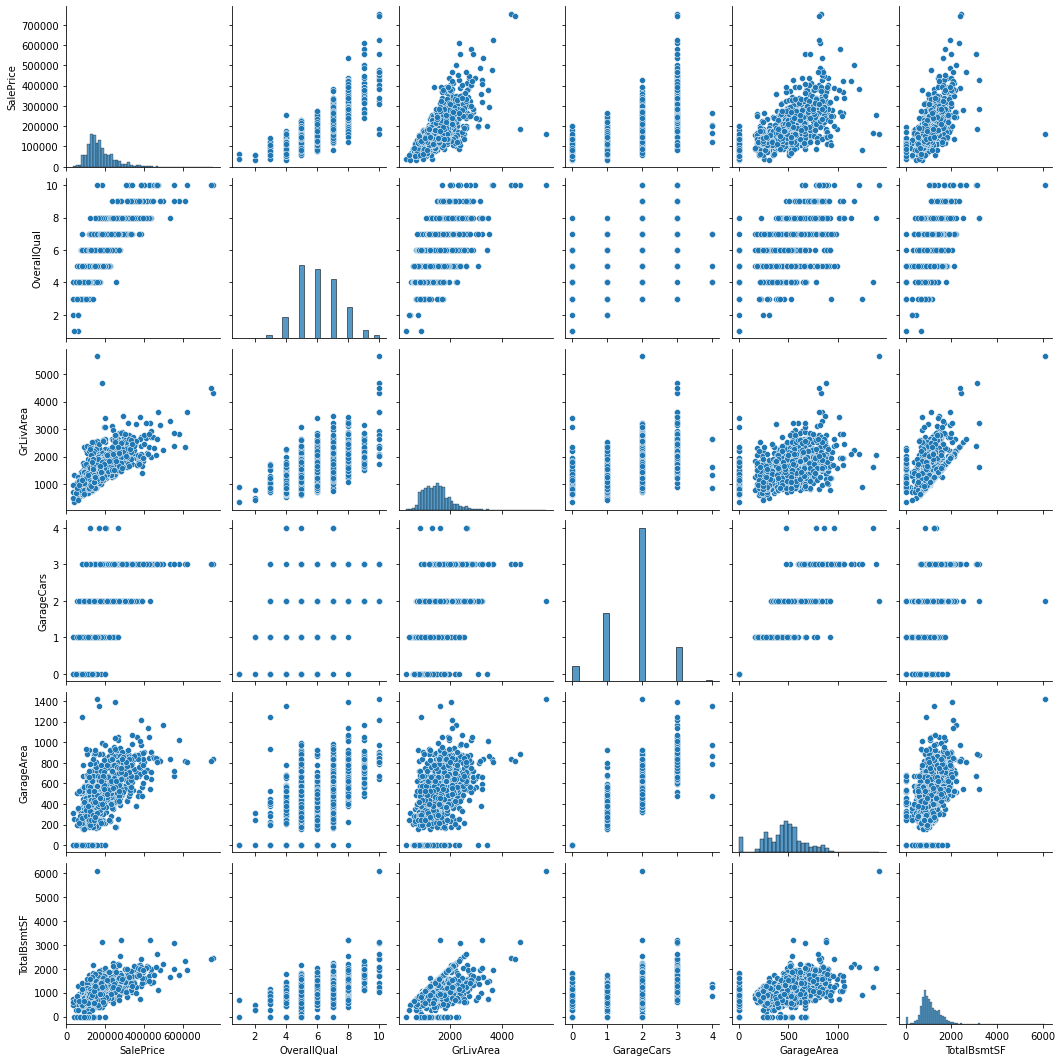

In [ ]:
# 집 값과 관련도가 가장 높은 속성들(여기서는 5개)을 추출해서 상관도 그래프를 그려봅니다.
cols=['SalePrice','OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF']
sns.pairplot(df[cols])
plt.show();

위 그래프에서 맨 왼쪽 열의 그림을 보십시요. 선택된 속성들이 집 값(SalePrice)와 양의 관계가 있음을 확인할 수 있습니다. 
* SalePrice vs. TotalBsmtSF
* SalePrice vs. GarageArea
* SalePrice vs. GarageCars
* SalePrice vs. GrLivArea
* SalePrice vs. OverallQual

## 4. 주택 가격 예측 모델
이제 앞서 고려한 중요 속성 5개 데이터로 학습 데이터 셋과 테스트 데이터셋을 만들어 보겠습니다. 집값을 y로 나머지 열을 X_train_pre로 저장한 후 전체 데이터셋의 80%를 학습 데이터셋으로 20%를 테스트 데이터셋으로 지정합니다.

In [ ]:
# 집 값을 제외한 나머지 열을 저장합니다. 
cols_train=['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF']
X_train_pre = df[cols_train]

# 집 값을 저장합니다.
y = df['SalePrice'].values

In [ ]:
# 전체의 80%를 학습셋으로, 20%를 테스트셋으로 지정합니다.
X_train, X_test, y_train, y_test = train_test_split(X_train_pre, y, test_size=0.2)

In [ ]:
# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1))
model.summary()

# 모델을 실행합니다.
model.compile(optimizer ='adam', loss = 'mean_squared_error')

# 20회 이상 결과가 향상되지 않으면 자동으로 중단되게끔 합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

# 모델의 이름을 정합니다.
modelpath="./data/model/Ch15-house.hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

# 실행 관련 설정을 하는 부분입니다. 전체의 20%를 검증셋으로 설정합니다. 
history = model.fit(X_train, y_train, validation_split=0.25, epochs=2000, batch_size=32, callbacks=[early_stopping_callback, checkpointer])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 30)                330       
                                                                 
 dense_2 (Dense)             (None, 40)                1240      
                                                                 
 dense_3 (Dense)             (None, 1)                 41        
                                                                 
Total params: 1,671
Trainable params: 1,671
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
28/28 [==============================] - 1s 6ms/step - loss: 38694957056.0000 - val_loss: 37385134080.0000
Epoch 2/2000
28/28 [==============================] - 0s 2ms/step 

#### [과제]
과제 1 - 실제 값(샘플) 20개를 뽑아 모델이 예측 값을 비교하는 그래프를 그리시오.다시 말해서 실제 값과 모델이 예측한 값을 한 그래프에 표시하시오.

과제 2 - 이 예제에서는 집가격과 상관 관계가 높은 5개 속성을 입력으로 고려했습니다. 집 가격과 상관간계가 폰은 7개를 속성을 입력으로 예측된 집 가격과 실제 집 가격을 비교 하시요.

In [ ]:
# 예측 값과 실제 값, 실행 번호가 들어갈 빈 리스트를 만듭니다.
real_prices =[]
pred_prices = []
X_num = []

# 25개의 샘플을 뽑아 실제 값, 예측 값을 출력해 봅니다. 
n_iter = 0
Y_prediction = model.predict(X_test).flatten()
for i in range(25):
    real = y_test[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.2f}, 예상가격: {:.2f}".format(real, prediction))
    real_prices.append(real)
    pred_prices.append(prediction)
    n_iter = n_iter + 1
    X_num.append(n_iter)

실제가격: 611657.00, 예상가격: 329255.75
실제가격: 245500.00, 예상가격: 181620.34
실제가격: 145000.00, 예상가격: 233795.81
실제가격: 265900.00, 예상가격: 205556.20
실제가격: 194500.00, 예상가격: 182455.28
실제가격: 341000.00, 예상가격: 284719.84
실제가격: 142000.00, 예상가격: 126574.13
실제가격: 131400.00, 예상가격: 138635.64
실제가격: 136905.00, 예상가격: 232640.91
실제가격: 230000.00, 예상가격: 213850.19
실제가격: 171750.00, 예상가격: 196477.75
실제가격: 105000.00, 예상가격: 130602.00
실제가격: 191000.00, 예상가격: 198079.19
실제가격: 196000.00, 예상가격: 191140.23
실제가격: 197000.00, 예상가격: 174349.61
실제가격: 110000.00, 예상가격: 125531.51
실제가격: 325000.00, 예상가격: 244239.45
실제가격: 145000.00, 예상가격: 128750.63
실제가격: 173000.00, 예상가격: 176292.86
실제가격: 105000.00, 예상가격: 156527.53
실제가격: 290000.00, 예상가격: 251117.11
실제가격: 147000.00, 예상가격: 150159.94
실제가격: 208300.00, 예상가격: 182757.31
실제가격: 139950.00, 예상가격: 163129.05
실제가격: 187100.00, 예상가격: 204657.23


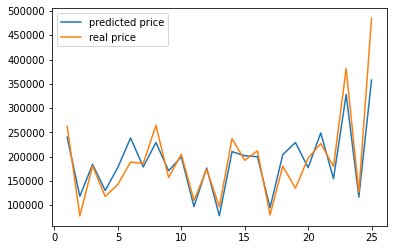

In [ ]:
# 그래프를 통해 샘플로 뽑은 25개의 값을 비교해 봅니다.

plt.plot(X_num, pred_prices, label='predicted price')
plt.plot(X_num, real_prices, label='real price')
plt.legend()
plt.show()